In [1]:
import numpy as np 
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from matplotlib.patches import Rectangle

# t-test
from scipy import stats

# regression - statsmodels
import statsmodels.regression.linear_model as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# regression - sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# sqrt
from math import sqrt

# Word Cloud
from wordcloud import WordCloud

# function for inserting a row to a location
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number]   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:]  
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
    # Return the updated dataframe 
    return df_result

In [3]:
data_ds=pd.read_csv('DataScientist.csv')
data_ds = data_ds.drop(['Unnamed: 0','index'],axis=1)

In [4]:
data = data_ds
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


In [5]:
# Check for missing values
def missing_values_table(df):
    # number of missing values
    mis_val = df.isnull().sum()
    # % of missing values
    mis_val_percent = 100 * mis_val / len(df)
    # make table # axis '0' concat along index, '1' column
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1) 
    # rename columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0:'Missing Values',1:'% of Total Values'})
    # sort by column
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values(
        '% of Total Values',ascending=False).round(1) #Review
    print("Your selected datset has "+str(df.shape[1])+" columns and "+str(len(df))+" observations.\n"
         "There are "+str(mis_val_table_ren_columns.shape[0])+" columns that have missing values.")
    # return the dataframe with missing info
    return mis_val_table_ren_columns

In [6]:
# replace rating values in string/bool to float
data['Rating'] = data['Rating'].astype(float)
data['Easy Apply'] = data['Easy Apply'].replace('True',1)

# Replace -1 or -1.0 or '-1' to NaN
data=data.replace(-1,np.nan)
data=data.replace(-1.0,np.nan)
data=data.replace('-1',np.nan)

In [7]:
#Remove Rating values from Company Name. 
data['Company Name'],_=data['Company Name'].str.split('\n', 1).str
# 1st column after split, 2nd column after split (delete when '_')
# string.split(separator, maxsplit) maxsplit default -1, which means all occurrances

# Split salary into two columns min salary and max salary.
data['Salary Estimate'],_=data['Salary Estimate'].str.split('(', 1).str

#exclude hourly rating salaries
data=data[(data['Salary Estimate'].str.contains(' Per Hour'))==False].reset_index(drop=True)

# Split salary into two columns min salary and max salary.
# lstrip is for removing leading characters; rstrip is for removing rear characters
data['Min_Salary'],data['Max_Salary']=data['Salary Estimate'].str.split('-').str
data['Min_Salary']=data['Min_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')
data['Max_Salary']=data['Max_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')

# To estimate the salary with regression and other analysis, better come up with one number: Est_Salary = (Min_Salary+Max_Salary)/2
data['Est_Salary']=(data['Min_Salary']+data['Max_Salary'])/2

# Create a variable for how many years a firm has been founded
data['Years_Founded'] = 2020 - data['Founded'].astype(float)

# Separate 'City' & 'State' from job 'Location'
data['City'],data['State'] = data['Location'].str.split(', ',1).str
data['HQCity'],data['HQState'] = data['Headquarters'].str.split(', ',1).str

# Clean up duplicated city names in State's name
data['State']=data['State'].replace('Arapahoe, CO','CO')
data['State']=data['State'].replace('Los Angeles, CA','CA')
data['HQState']=data['HQState'].replace('NY (US), NY','NY')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


In [8]:
# Group up number of hires by company's revenue
RevCount = data.groupby('Revenue')[['Job Title']].count().reset_index().rename(columns={'Job Title':'Hires'}).sort_values(
    'Hires', ascending=False).reset_index(drop=True)
#Make the Revenue column clean
RevCount["Revenue_USD"]=['Unknown','10+ billion','100-500 million','50-100 million','2-5 billion','10-25 million','1-2 billion','1-5 million','25-50 million','5-10 billion','<1 million','0.5-1 billion','5-10 million']
#Merge the new Revenue back to data
RevCount2 = RevCount[['Revenue','Revenue_USD']]
RevCount = RevCount.merge(data, on='Revenue',how='left')
data=data.merge(RevCount2,on='Revenue',how='left')

In [9]:
missing_values_table(data)

Your selected datset has 24 columns and 3888 observations.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Easy Apply,3725,95.8
Competitors,2743,70.6
Founded,970,24.9
Years_Founded,970,24.9
Industry,543,14.0
Sector,543,14.0
Rating,405,10.4
Headquarters,240,6.2
HQCity,240,6.2
HQState,240,6.2


In [10]:
# create a new dataset from original data
text_Analysis = data[['Job Title','Job Description',
                      'Est_Salary','Max_Salary','Min_Salary',
                      'City','State','Easy Apply',
                      'Revenue_USD','Rating','Size',
                      'Industry','Sector','Type of ownership',
                      'Years_Founded','Company Name','HQState']]

# write get_keyword function
def get_keyword(x, note, VarSet):
   x_ = x.split(" ")
   keywords = []
   try:
      for word in x_:
         if word + note in np.asarray(VarSet):
            keywords.append(word + note)
   except:
      return -1

   return keywords

In [11]:
#Remove special characters.
text_Analysis['Revenue_USD'] = text_Analysis['Revenue_USD'].replace('Unknown','RevUnknown')
text_Analysis['Size'] = text_Analysis['Size'].replace('Unknown','SizeUnknown')
text_Analysis['Sector'] = text_Analysis['Sector'].replace('[^A-Za-z0-9]+', '_',regex=True).replace(['Government','Unknown'],['GovSec','SectorUnknown'])
text_Analysis['Industry'] = text_Analysis['Industry'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','IndUnknown')
text_Analysis['Type of ownership'] = text_Analysis['Type of ownership'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','OwnUnknown')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [15]:
data

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,Easy Apply,Min_Salary,Max_Salary,Est_Salary,Years_Founded,City,State,HQCity,HQState,Revenue_USD
0,Senior Data Scientist,$111K-$181K,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper,"New York, NY","Montreal, Canada",501 to 1000 employees,2007.0,Company - Private,...,NaN,111,181,146.0,13.0,New York,NY,Montreal,Canada,Unknown
1,"Data Scientist, Product Analytics",$111K-$181K,"At Noom, we use scientifically proven methods ...",4.5,Noom US,"New York, NY","New York, NY",1001 to 5000 employees,2008.0,Company - Private,...,NaN,111,181,146.0,12.0,New York,NY,New York,NY,Unknown
2,Data Science Manager,$111K-$181K,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,NaN,Decode_M,"New York, NY","New York, NY",1 to 50 employees,NaN,Unknown,...,1.0,111,181,146.0,NaN,New York,NY,New York,NY,Unknown
3,Data Analyst,$111K-$181K,Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019.0,Company - Private,...,NaN,111,181,146.0,1.0,Lyndhurst,NJ,Lyndhurst,NJ,Unknown
4,"Director, Data Science",$111K-$181K,"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group,"New York, NY","New York, NY",51 to 200 employees,2007.0,Company - Private,...,NaN,111,181,146.0,13.0,New York,NY,New York,NY,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,AWS Data Engineer,$55K-$112K,About Us\n\nTachyon Technologies is a Digital ...,4.4,Tachyon Technologies,"Dublin, OH","Irving, TX",201 to 500 employees,2011.0,Company - Private,...,NaN,55,112,83.5,9.0,Dublin,OH,Irving,TX,10-25 million
3884,Data Analyst â Junior,$55K-$112K,"Job description\nInterpret data, analyze resul...",5.0,"Staffigo Technical Services, LLC","Columbus, OH","Woodridge, IL",51 to 200 employees,2008.0,Company - Private,...,NaN,55,112,83.5,12.0,Columbus,OH,Woodridge,IL,50-100 million
3885,Security Analytics Data Engineer,$55K-$112K,Job DescriptionThe Security Analytics Data Eng...,3.8,"PDS Tech, Inc.","Dublin, OH","Irving, TX",5001 to 10000 employees,1977.0,Company - Private,...,NaN,55,112,83.5,43.0,Dublin,OH,Irving,TX,100-500 million
3886,Security Analytics Data Engineer,$55K-$112K,The Security Analytics Data Engineer will inte...,4.0,Data Resource Technologies,"Dublin, OH","Omaha, NE",1 to 50 employees,NaN,Company - Private,...,NaN,55,112,83.5,NaN,Dublin,OH,Omaha,NE,<1 million


In [17]:
ssize = 30
text_Analysis = text_Analysis.rename(columns={"Easy Apply":"Easy_Apply"})
# remove special characters and unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job Title'].str.upper().replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['Â','AND ','WITH ','SYSTEMS','OPERATIONS','ANALYTICS','SERVICES','ENGINEERS','NETWORKS','GAMES','MUSICS','INSIGHTS','SOLUTIONS','JR ','MARKETS','STANDARDS','FINANCE','PRODUCTS','DEVELOPERS','SR ',' 2'],
    ['','','','SYSTEM','OPERATION','ANALYTIC','SERVICE','ENGINEER','NETWORK','GAME','MUSIC','INSIGHT','SOLUTION','JUNIOR ','MARKET','STANDARD','FINANCIAL','PRODUCT','DEVELOPER','SENIOR ',' II'],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['BUSINESS INTELLIGENCE','INFORMATION TECHNOLOGY','QUALITY ASSURANCE','USER EXPERIENCE','USER INTERFACE','DATA WAREHOUSE','DATA ANALYST','DATA BASE','DATA QUALITY','DATA GOVERNANCE','BUSINESS ANALYST','DATA MANAGEMENT','REPORTING ANALYST','BUSINESS DATA','SYSTEM ANALYST','DATA REPORTING','QUALITY ANALYST','DATA ENGINEER','BIG DATA','SOFTWARE ENGINEER','MACHINE LEARNING','FULL STACK','DATA SCIENTIST','DATA SCIENCE','DATA CENTER','ENTRY LEVEL','NEURAL NETWORK','SYSTEM ENGINEER',' ML '],
    ['BI','IT','QA','UX','UI','DATA_WAREHOUSE','DATA_ANALYST','DATABASE','DATA_QUALITY','DATA_GOVERNANCE','BUSINESS_ANALYST','DATA_MANAGEMENT','REPORTING_ANALYST','BUSINESS_DATA','SYSTEM_ANALYST','DATA_REPORTING','QUALITY_ANALYST','DATA_ENGINEER','BIG_DATA','SOFTWARE_ENGINEER','MACHINE_LEARNING','FULL_STACK','DATA_SCIENTIST','DATA_SCIENCE','DATA_CENTER','ENTRY_LEVEL','NEURAL_NETWORK','SYSTEM_ENGINEER',' MACHINE_LEARNING '],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['DATA_ENGINEER JUNIOR','DATA_ENGINEER SENIOR','DATA  REPORTING_ANALYST','DATA ','BIG_DATA '],
    ['JUNIOR DATA_ENGINEER','SENIOR DATA_ENGINEER','DATA_REPORTING_ANALYST','DATA_','BIG_DATA_'],regex=True)

# get top keywords
s = text_Analysis['Job_title_2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S = s[s['Count']>ssize]

# get keywords from each row
text_Analysis['KW'] = text_Analysis['Job_title_2'].apply(lambda x: get_keyword(x,'',S['KW']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['KW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True).replace(np.nan,0)

In [18]:
# Create a list of big data buzzwords to see if those words in JD would influence the salary
buzzwords = ['COMPUTER_SCIENCE','MASTER','MBA','SQL','PYTHON','R','PHD','BUSINESS_ANALYTICS','SAS','PMP','SCRUM_MASTER','STATISTICS','MATHEMATICS','MACHINE_LEARNING','ARTIFICIAL_INTELLIGENCE','ECONOMICS','TABEAU','AWS','AZURE','POWER_BI','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','REGRESSION','CLUSTER','ORACLE','EXCEL','TENSORFLOW','HADOOP','SPARK','NOSQL','SAP','ETL','API','PLSQL','MONGODB','POSTGRESQL','ELASTICSEARCH','REDIS','MYSQL','FIREBASE','SQLITE','CASSANDRA','DYNAMODB','OLTP','OLAP','DEVOPS','PLATFORM','NETWORK','APACHE','SECURITY','MARKDOWN']
# remove special characters and unify some word use
text_Analysis['Job_Desc2'] = text_Analysis['Job Description'].replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_Desc2'] = text_Analysis['Job_Desc2'].str.upper().replace(
    ['COMPUTER SCIENCE','ENGINEERING DEGREE',' MS ','BUSINESS ANALYTICS','SCRUM MASTER','MACHINE LEARNING',' ML ','POWER BI','ARTIFICIAL INTELLIGENCE',' AI ','ALGORITHMS','DEEP LEARNING','NEURAL NETWORK','NATURAL LANGUAGE PROCESSING','DECISION TREE','CLUSTERING','PL SQL'],
    ['COMPUTER_SCIENCE','ENGINEERING_DEGREE',' MASTER ','BUSINESS_ANALYTICS','SCRUM_MASTER','MACHINE_LEARNING',' MACHINE_LEARNING ','POWER_BI','ARTIFICIAL_INTELLIGENCE',' ARTIFICIAL_INTELLIGENCE ','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','CLUSTER','PLSQL'],regex=True)

# Count the JD keywords.
S2 = text_Analysis['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S2 = S2[S2['KW'].isin(buzzwords)].reset_index(drop=True)
S2['KWJD'] = S2['KW'] + '_JD'
S2 = S2[S2['Count']>ssize]

# get keywords from each row
text_Analysis['JDKW'] = text_Analysis['Job_Desc2'].apply(lambda x: get_keyword(x,'_JD',S2['KWJD']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['JDKW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

In [19]:
# let's see if number of buzzwords contained or how wordy the JD is would have impact.
text_Analysis['JDKWlen']=text_Analysis['JDKW'].str.len()
text_Analysis['JDlen']=text_Analysis['Job Description'].str.len()

In [20]:
## State ##
# Count the states frequency for t-test later
S3 = text_Analysis['State'].value_counts().reset_index().rename(
    columns={'index':'State','State':'Count'})
S3_Top = S3[S3['Count']>ssize]

# create dummy columns by State
kwdummy = pd.get_dummies(text_Analysis['State'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## City ##
text_Analysis['City']=text_Analysis['City'].str.replace(' ','_',regex=True)

# Count the city frequency for t-test later
S35 = text_Analysis['City'].value_counts().reset_index().rename(
    columns={'index':'City','City':'Count'})
S35_Top = S35[S35['Count']>ssize]

# create dummy columns by City
kwdummy = pd.get_dummies(text_Analysis[text_Analysis['City'].isin(np.asarray(S35_Top['City']))]['City'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## State where companies Headquarters locate at  ##
# Count the HQState frequency for t-test later
S31 = text_Analysis['HQState'].value_counts().reset_index().rename(
    columns={'index':'HQState','HQState':'Count'}).replace(0,'Unknown_State')
S31['HQState_HQ'] = [s + '_HQ' for s in S31['HQState']]
S31_Top = S31[S31['Count']>ssize]

# create dummy columns by HQ State
kwdummy = pd.get_dummies(S31_Top['HQState_HQ'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
S31_Top2 = S31_Top.merge(kwdummy,left_index=True,right_index=True,how='left').drop(['Count'],axis=1)
text_Analysis = text_Analysis.merge(S31_Top2,on='HQState',how='left').replace(np.nan,0)

In [21]:
# create dummy columns by Revenue
kwdummy = pd.get_dummies(text_Analysis['Revenue_USD'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Revenue frequency for t-test later
S4 = text_Analysis['Revenue_USD'].value_counts().reset_index().rename(
    columns={'index':'Revenue_USD','Revenue_USD':'Count'})
S4_Top = S4[(S4['Count']>ssize) & (S4['Revenue_USD']!=0)]

# create dummy columns by Size
kwdummy = pd.get_dummies(text_Analysis['Size'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Size frequency for t-test later
S5 = text_Analysis['Size'].value_counts().reset_index().rename(
    columns={'index':'Size','Size':'Count'})
S5_Top = S5[(S5['Count']>ssize) & (S5['Size']!=0)]

# create dummy columns by Sector
kwdummy = pd.get_dummies(text_Analysis['Sector'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Sector frequency for t-test later
S6 = text_Analysis['Sector'].value_counts().reset_index().rename(
    columns={'index':'Sector','Sector':'Count'})
S6 = S6[S6['Sector']!=0]
S6_Top = S6[(S6['Count']>ssize)]

# create dummy columns by Type of Ownership
kwdummy = pd.get_dummies(text_Analysis['Type of ownership'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Type of ownership frequency for t-test later
S8 = text_Analysis['Type of ownership'].value_counts().reset_index().rename(
    columns={'index':'Type_of_ownership','Type of ownership':'Count'})
S8_Top = S8[(S8['Count']>ssize) & (S8['Type_of_ownership']!=0)]


In [30]:
data.head()
data.to_excel('dt.xlsx')

In [28]:
# SA = s[s['KW'].str.contains('ANALYST')].reset_index(drop=True).drop([0,2,4,8,10,11,15])
# SBA = s[s['KW'].str.contains('BUSINESS_ANALYST')].reset_index(drop=True)
# SDA = s[s['KW'].str.contains('DATA_ANALYST')].reset_index(drop=True)
# SDE1 = s[s['KW'].str.contains('DATA_ENGINEER')].reset_index(drop=True).drop([2,4])
SDS = s[s['KW'].str.contains('DATA_SCIENTIST')].reset_index(drop=True)
# SSE = s[s['KW'].str.contains('SOFTWARE_ENGINEER')].reset_index(drop=True).drop([1])

# SDE = []
# SDE = pd.concat([SDE1,SSE])

# SA['Group']='Other Analysts'
# SBA['Group']='Business Analysts'
# SDA['Group']='Data Analysts'
# SDE['Group']='Data Engineers'
SDS['Group']='Data Scientists'

All_DS_Jobs=[]
# All_DS_Jobs=pd.concat([SA,SBA,SDA,SDE,SDS]).sort_values('Count',ascending=False).reset_index(drop=True)
ALL_DS_Jobs = SDS
# All_DS_Jobs_sum=All_DS_Jobs.groupby('Group')['Count'].sum().reset_index().sort_values(
#     'Count',ascending=False).reset_index(drop=True).rename(columns={'Count':'Hires','Group':'Positions'})
All_DS_Jobs_sum=SDS

# fig = plt.figure(figsize=(7, 7))
# labels = All_DS_Jobs_sum['Positions']
# plt.pie(All_DS_Jobs_sum['Hires'], shadow=True, startangle=90, autopct='%1.1f%%', labels=labels)
# plt.title('Data Science Job Composition\n(% in number of hires)',color='darkblue',fontsize=16)
# plt.show()

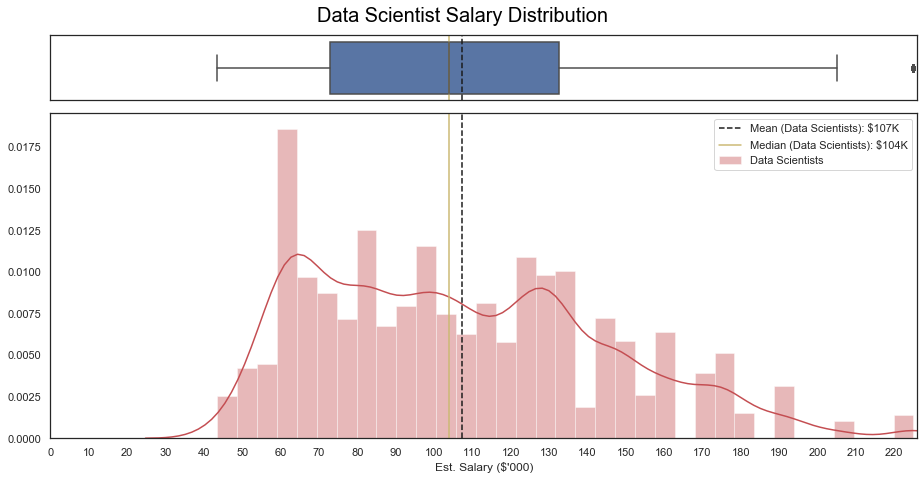

In [280]:
dss = position_sal['Est_Salary']

sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=dss.mean()
median=dss.median()

bph = sns.boxplot(dss, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

des1 = sns.distplot(dss,ax=ax_hist, color="r").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Scientists): $'+str(int(mean))+'K':mean,
            'Median (Data Scientists): $'+str(int(median))+'K':median,'Data Scientists':dss})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Scientist Salary Distribution', fontsize=20,color='black')
plt.show()


In [42]:
plt.savefig('DT.png')

<Figure size 432x288 with 0 Axes>

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import time
#import shapely
#import geopandas as gpd
from scipy import ndimage
from pandas.io.gbq import read_gbq
plt.rcParams["figure.dpi"] = 400
pylab.rcParams['figure.figsize'] = 8, 6
np.set_printoptions(precision=3, suppress=True)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from os import path
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
# from spellchecker import SpellChecker
from textblob import TextBlob, Word, Blobber
import plotly.tools as tls
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import chart_studio.plotly as py
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [277]:
train = pd.read_excel("DTD.xlsx")



In [278]:
train['JT'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    legend=dict(),
    yTitle='count',
    title='Senior and Entry Level Data Science Job Distribution')

In [264]:
# Calculating Sentiment Polarity , Review Length and Word Count of each review.
train['Sentiment Polarity'] = train['Job Description'].apply(lambda text: TextBlob(text).sentiment.polarity)
train['Review Length'] = train['Job Description'].astype(str).apply(len)
train['Word Count'] = train['Job Description'].apply(lambda x: len(str(x).split()))
# test['Sentiment Polarity'] = test['JD'].map(lambda text: TextBlob(text).sentiment.polarity)
# test['Review Length'] = test['JD'].astype(str).apply(len)
# test['Word Count'] = test['JD'].apply(lambda x: len(str(x).split()))

In [109]:
train['Review Length'].iplot(
    kind='hist',
    bins=100,
    xTitle='JD length',
    linecolor='black',
    legend=dict(),
    yTitle='count',
    title='JD Text Length Distribution')

In [110]:
train['Word Count'].iplot(
    kind='hist',
    bins=100,
    xTitle='JD word count',
    linecolor='black',
    legend=dict(),
    yTitle='count',
    title='JD Word Count Distribution')

In [265]:
#Plotting the Sentiment Polarity of each document using iplot.
train['Sentiment Polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='Polarity',
    linecolor='black',
    legend=dict(),
    yTitle='Count',
    title='Sentiment Polarity Distribution before Text Processing')

for detecting the gender bias in JD , we can mining the text with PCA and LDA for detecting the difference

In [266]:
train["clean_text"] = None # create a new column to store clean text
#convert the text to lower case. 
train['clean_text'] = data['JD'].apply(lambda x: " ".join(x.lower() for x in x.split(" ")))

In [267]:
# defining all the concordance in a dictionary.

Con_appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
    "shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
    "you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [268]:
train['clean_text'] = train['clean_text'].apply(lambda x:" ".join(Con_appos[x] if x in Con_appos else x for x in x.split(" ") ))

nltk.download('wordnet')
# use of wordnet lemmatization.
train['clean_text'] = train['clean_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# test['clean_text'] = test['clean_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['clean_text'].head()

[nltk_data] Downloading package wordnet to C:\Users\yuzi
[nltk_data]     han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    read what people are saying about working here...
1    we have an immediate opening for a sharp data ...
2    candidate should have the following background...
3    read what people are saying about working here...
4    we are seeking an extraordinary data scientist...
Name: clean_text, dtype: object

In [269]:
#Frequency of top 25 most frequent words.
freq = pd.DataFrame(pd.Series(' '.join(train['clean_text']).split()).value_counts()[:25])
#Resetting the index of frequency
freq=freq.reset_index()

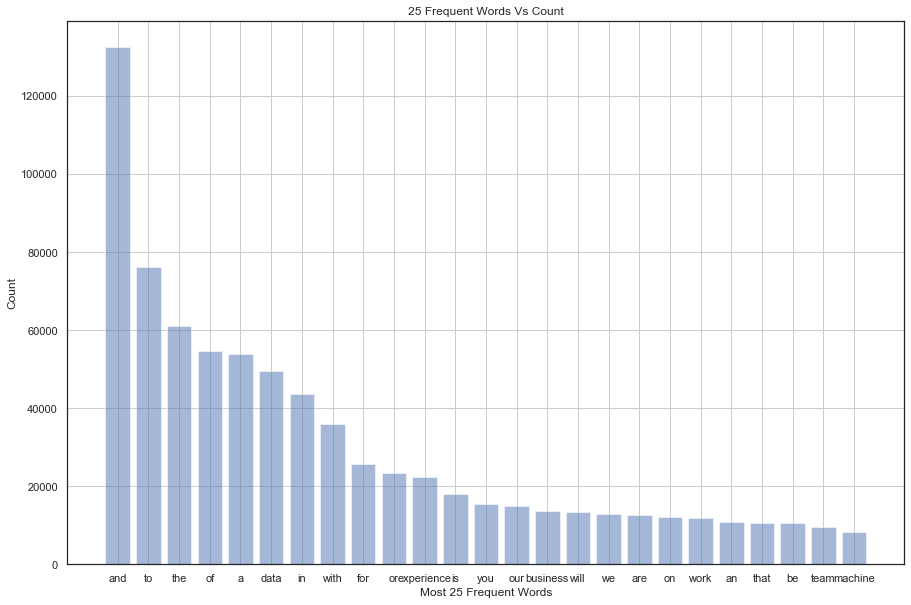

In [270]:
#Plotting the top 25 most frequent words using Matplot
plt.figure(figsize=(15,10))
plt.grid(True)
plt.bar(freq['index'], freq[0], align='center', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Most 25 Frequent Words')
plt.title('25 Frequent Words Vs Count')
plt.rcParams.update({'font.size': 11})
plt.show()

In [173]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
import pandas as pd

# data = pd.read_csv('DS.csv', error_bad_lines=False)
data = pd.read_excel("DTD.xlsx")
# data = pd.read_csv('DTD.csv',error_bad_lines=False)
data_text = data[['JD']]
data_text['index'] = data_text.index
documents = data_text

[nltk_data] Downloading package wordnet to C:\Users\yuzi
[nltk_data]     han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [174]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [188]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 5:
            result.append(lemmatize_stemming(token))
    return result

In [189]:
doc_sample = documents[documents['index'] == 400].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Job', 'Title:?Data', 'Scientist', 'Location:?Basking', 'Ridge,', 'NJ?????', '????', 'Type:-Contract', '?', 'Primary', 'Skills:?Data', 'Science,', 'Python,', 'R', 'Language,', 'Oracle', 'PL/SQL', '?', 'Description:', 'Create', 'processes', 'in', 'support', 'of', 'data', 'science', 'projects', 'using', 'Python', 'and', 'R', 'languages', 'Perform', 'analysis', 'on', 'current', 'trends', 'and', 'monitor', 'system', 'effectiveness', 'Translate', 'analysis', 'into', 'system', 'recommendations', '?', 'Required', 'Skills/Experience:', 'Experience', 'using', 'Python', 'or', 'R', 'for', 'data', 'analysis', 'Oracle', 'PL/SQL', 'Proficiency', 'General', 'SQL', 'proficiency', 'across', 'vendors', '(Oracle,', 'Postgres,', 'Teradata)', 'Strong', 'analytical', 'skills', 'Strong', 'written', 'and', 'verbal', 'communication', 'Ability', 'to', 'work', 'independently', 'on', 'issues', "Bachelor's", 'Degree', 'in', 'Computer', 'Science', 'or', 'Math/Statistics', '2', 'years', 'analysi

In [190]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\yuzi
[nltk_data]     han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [191]:
# processed_docs = documents['JD'].map(preprocess)

In [192]:
documents = documents.dropna(subset=['JD'])
documents['JD'].fillna('').astype(str).map(preprocess)

0       [peopl, say, work, farmer, divers, profession,...
1       [immedi, open, scientist, strong, mathemat, st...
2       [candid, follow, background, skill, characteri...
3       [peopl, say, work, blackrock, blackrock, inves...
4       [seek, extraordinari, scientist, charlott, gro...
                              ...                        
9995    [upstart, futur, credit, upstart, lend, platfo...
9996    [scientist, princip, realtor, realtor, process...
9997    [summari, revolut, interact, contribut, produc...
9998    [scientist, princip, realtor, realtor, process...
9999    [scientist, princip, realtor, realtor, process...
Name: JD, Length: 10000, dtype: object

In [193]:
processed_docs = documents['JD'].map(preprocess)

In [207]:
processed_docs 

0       [peopl, say, work, farmer, divers, profession,...
1       [immedi, open, scientist, strong, mathemat, st...
2       [candid, follow, background, skill, characteri...
3       [peopl, say, work, blackrock, blackrock, inves...
4       [seek, extraordinari, scientist, charlott, gro...
                              ...                        
9995    [upstart, futur, credit, upstart, lend, platfo...
9996    [scientist, princip, realtor, realtor, process...
9997    [summari, revolut, interact, contribut, produc...
9998    [scientist, princip, realtor, realtor, process...
9999    [scientist, princip, realtor, realtor, process...
Name: JD, Length: 10000, dtype: object

In [208]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [272]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 100:
        break

0 action
1 career
2 client
3 databas
4 decis
5 divers
6 educ
7 excel
8 function
9 implement
10 innov
11 intellig
12 intern
13 master
14 method
15 peopl
16 predict
17 prefer
18 present
19 profession
20 profici
21 quantit
22 report
23 respons
24 result
25 servic
26 sourc
27 structur
28 summari
29 algorithm
30 candid
31 look
32 mathemat
33 organ
34 softwar
35 bachelor
36 build
37 hadoop
38 optim
39 system
40 analyz
41 collabor
42 complex
43 custom
44 deliv
45 descript
46 disabl
47 drive
48 effect
49 gender
50 ident
51 identifi
52 impact
53 improv
54 insight
55 languag
56 lead
57 multipl
58 nation
59 orient
60 origin
61 partner
62 practic
63 protect
64 qualifi
65 recommend
66 regard
67 religion
68 sexual
69 solv
70 status
71 success
72 veteran
73 benefit
74 chang
75 creat
76 employe
77 execut
78 industri
79 locat
80 senior
81 appli
82 demonstr
83 integr
84 market
85 qualiti
86 research
87 write
88 oper
89 person
90 platform
91 visual
92 mine
93 qualif
94 member
95 relev
96 direct
97 expert

In [273]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100)

In [274]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[400]

[(17, 1),
 (20, 2),
 (34, 2),
 (35, 2),
 (38, 1),
 (45, 1),
 (48, 1),
 (55, 2),
 (65, 1),
 (75, 1),
 (79, 1),
 (87, 1)]

In [275]:
bow_doc_4310 = bow_corpus[600]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 1 ("career") appears 1 time.
Word 4 ("decis") appears 1 time.
Word 6 ("educ") appears 1 time.
Word 8 ("function") appears 3 time.
Word 9 ("implement") appears 2 time.
Word 12 ("intern") appears 4 time.
Word 13 ("master") appears 1 time.
Word 14 ("method") appears 1 time.
Word 15 ("peopl") appears 1 time.
Word 16 ("predict") appears 3 time.
Word 17 ("prefer") appears 1 time.
Word 19 ("profession") appears 1 time.
Word 20 ("profici") appears 3 time.
Word 21 ("quantit") appears 1 time.
Word 23 ("respons") appears 1 time.
Word 25 ("servic") appears 4 time.
Word 27 ("structur") appears 1 time.
Word 29 ("algorithm") appears 1 time.
Word 30 ("candid") appears 2 time.
Word 32 ("mathemat") appears 1 time.
Word 33 ("organ") appears 2 time.
Word 36 ("build") appears 3 time.
Word 38 ("optim") appears 2 time.
Word 42 ("complex") appears 4 time.
Word 43 ("custom") appears 1 time.
Word 44 ("deliv") appears 2 time.
Word 45 ("descript") appears 2 time.
Word 54 ("insight") appears 2 time.
Word 61 (

In [216]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

corpus_tfidf = tfidf[bow_corpus]

In [217]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1261817401409507),
 (1, 0.15314128537759134),
 (2, 0.1346933471202145),
 (3, 0.13418081791381023),
 (4, 0.10199359540750011),
 (5, 0.3160585525463357),
 (6, 0.15649504098640263),
 (7, 0.13883206579631124),
 (8, 0.24579513726303057),
 (9, 0.10179537644153874),
 (10, 0.11109814908283981),
 (11, 0.1455247947940983),
 (12, 0.1527599644677759),
 (13, 0.11421158666171156),
 (14, 0.11995735357309795),
 (15, 0.11644695590707572),
 (16, 0.08986843922622466),
 (17, 0.08790082150529639),
 (18, 0.11628823815000587),
 (19, 0.13702573591425599),
 (20, 0.5105811800964596),
 (21, 0.37598138292267264),
 (22, 0.1463264701600741),
 (23, 0.13883206579631124),
 (24, 0.11552914829751709),
 (25, 0.185414138287569),
 (26, 0.11817389731036997),
 (27, 0.16156211326699502),
 (28, 0.1521690702707207)]


In [260]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=5)

In [261]:
for idx, topic in lda_model.print_topics(20):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"prefer" + 0.024*"algorithm" + 0.023*"softwar" + 0.022*"optim" + 0.021*"languag" + 0.020*"industri" + 0.019*"status" + 0.017*"collabor" + 0.017*"innov" + 0.017*"oper"
Topic: 1 
Words: 0.027*"client" + 0.026*"predict" + 0.024*"oper" + 0.022*"research" + 0.021*"algorithm" + 0.020*"method" + 0.020*"sourc" + 0.020*"identifi" + 0.019*"complex" + 0.019*"visual"
Topic: 2 
Words: 0.027*"servic" + 0.024*"market" + 0.023*"function" + 0.023*"predict" + 0.022*"prefer" + 0.022*"effect" + 0.022*"complex" + 0.021*"employe" + 0.018*"collabor" + 0.016*"languag"
Topic: 3 
Words: 0.068*"custom" + 0.029*"insight" + 0.028*"servic" + 0.020*"present" + 0.019*"decis" + 0.019*"market" + 0.019*"predict" + 0.017*"improv" + 0.016*"deliv" + 0.015*"complex"
Topic: 4 
Words: 0.032*"client" + 0.032*"servic" + 0.025*"industri" + 0.020*"protect" + 0.020*"status" + 0.018*"insight" + 0.018*"locat" + 0.018*"custom" + 0.017*"innov" + 0.017*"disabl"
Topic: 5 
Words: 0.052*"research" + 0.021*"qualif" +

In [233]:
processed_docs[400]

['scientist',
 'locat',
 'bask',
 'contract',
 'primari',
 'skill',
 'scienc',
 'python',
 'languag',
 'oracl',
 'descript',
 'creat',
 'process',
 'support',
 'scienc',
 'project',
 'python',
 'languag',
 'perform',
 'analysi',
 'current',
 'trend',
 'monitor',
 'effect',
 'translat',
 'analysi',
 'recommend',
 'requir',
 'skill',
 'experi',
 'experi',
 'python',
 'analysi',
 'oracl',
 'profici',
 'general',
 'profici',
 'vendor',
 'oracl',
 'postgr',
 'teradata',
 'strong',
 'analyt',
 'skill',
 'strong',
 'write',
 'verbal',
 'communic',
 'abil',
 'independ',
 'issu',
 'bachelor',
 'degre',
 'scienc',
 'statist',
 'analysi',
 'experi',
 'analysi',
 'softwar',
 'enterpris',
 'python',
 'statist',
 'packag',
 'scikitlearn',
 'addit',
 'prefer',
 'skill',
 'oracl',
 'strong',
 'background',
 'statist',
 'manag',
 'model',
 'experi',
 'experi',
 'deploy',
 'maintain',
 'machin',
 'learn',
 'model',
 'experi',
 'deploy',
 'mainten',
 'optim',
 'bachelor',
 'degre',
 'scienc',
 'softwar']

In [259]:
for index, score in sorted(lda_model[bow_corpus[1000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 30)))


Score: 0.9794763922691345	 
Topic: 0.007*"" + 0.003*"we" + 0.003*"analytics" + 0.003*"your" + 0.003*"science" + 0.003*"such" + 0.003*"The" + 0.003*"including" + 0.003*"technical" + 0.003*"-" + 0.003*"this" + 0.002*"tools" + 0.002*"complex" + 0.002*"more" + 0.002*"their" + 0.002*"all" + 0.002*"analytical" + 0.002*"degree" + 0.002*"advanced" + 0.002*"development" + 0.002*"into" + 0.002*"knowledge" + 0.002*"support" + 0.002*"techniques" + 0.002*"Experience" + 0.002*"ability" + 0.002*"&" + 0.002*"predictive" + 0.002*"help" + 0.002*"across"

Score: 0.02052360028028488	 
Topic: 0.549*"" + 0.028*"
" + 0.001*"-" + 0.001*"You" + 0.001*"science" + 0.001*"we" + 0.001*"your" + 0.001*"Experience" + 0.001*"such" + 0.001*"code" + 0.001*"analytics" + 0.001*"this" + 0.001*"tools" + 0.001*"Location" + 0.001*"all" + 0.001*"Posted" + 0.001*"knowledge" + 0.001*"

" + 0.001*"Summary

" + 0.001*"development" + 0.001*"technical" + 0.001*"Reference" + 0.001*"The" + 0.001*"including" + 0.001*"more" + 0.001*"Jo

In [223]:
import json
class NumPyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64) or isinstance(obj, np.int32):
            return int(obj)
        if isinstance(obj, np.float64) or isinstance(obj, np.float32):
            return float(obj)
        if np.iscomplexobj(obj):
            return np.real(obj)
        return json.JSONEncoder.default(self, obj)

In [238]:
texts=list(data['JD'])
texts=[i.split(" ") for i in texts]
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.LdaMulticore(corpus, num_topics=2, id2word=id2word, passes=6, workers=5)
corpus = [id2word.doc2bow(text) for text in texts]
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
pyLDAvis.enable_notebook()
prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')

# vis = pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
# vis
# pyLDAvis.show(prepared,open_browser=False)
pyLDAvis.display(prepared)